In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
tf.enable_eager_execution()
import importlib
import os

from matplotlib import pyplot as plt
%matplotlib notebook

from transliteration import data, train, model_one, script, decode, evaluate

In [2]:
importlib.reload(data)
batch_size = 50
muse_train_dataset = data.make_dataset('../data/tfrecord/muse_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_valid_dataset = data.make_dataset('../data/tfrecord/muse_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
muse_test_dataset = data.make_dataset('../data/tfrecord/muse_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)
cmu_train_dataset = data.make_dataset('../data/tfrecord/cmu_train.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_valid_dataset = data.make_dataset('../data/tfrecord/cmu_valid.tfrecord',
                                  from_script='en',
                                  to_script='cmu',
                                  batch_size=batch_size)
cmu_test_dataset = data.make_dataset('../data/tfrecord/cmu_test.tfrecord',
                                 from_script='en',
                                 to_script='cmu',
                                 batch_size=batch_size)
eob_train_dataset = data.make_dataset('../data/tfrecord/eob_train.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_valid_dataset = data.make_dataset('../data/tfrecord/eob_valid.tfrecord',
                                       from_script='en',
                                       to_script='ja',
                                       batch_size=batch_size)
eob_test_dataset = data.make_dataset('../data/tfrecord/eob_test.tfrecord',
                                      from_script='en',
                                      to_script='ja',
                                      batch_size=batch_size)

In [3]:
importlib.reload(model_one)
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred)
    return tf.reduce_mean(loss_ * mask)

cmu_encoder_config = model_one.Config(lstm_size=240,
                                      embedding_size=30,
                                      attention_size=None,
                                      vocab_size=script.SCRIPTS['en'].vocab_size)
ja_encoder_config = model_one.Config(lstm_size=60,
                                      embedding_size=20,
                                      attention_size=None,
                                      vocab_size=script.SCRIPTS['en'].vocab_size)
ja_decoder_config = model_one.Config(lstm_size=80,
                                     embedding_size=30,
                                     attention_size=60,
                                     attention='monotonic_bahdanau',
                                     vocab_size=script.SCRIPTS['ja'].vocab_size)
cmu_decoder_config = model_one.Config(lstm_size=240,
                                  embedding_size=30,
                                  attention_size=120,
                                  attention='monotonic_bahdanau',
                                  vocab_size=script.SCRIPTS['cmu'].vocab_size)
cmu_encoder = model_one.Encoder(cmu_encoder_config)
ja_encoder = model_one.CombinedEncoder(ja_encoder_config, cmu_encoder)
ja_decoder = model_one.Decoder(ja_decoder_config)
cmu_decoder = model_one.Decoder(cmu_decoder_config)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 cmu_encoder=cmu_encoder,
                                 ja_encoder=ja_encoder,
                                 ja_decoder=ja_decoder,
                                 cmu_decoder=cmu_decoder)

Instructions for updating:
Colocations handled automatically by placer.


'./training_checkpoints/ckpt-1'

In [4]:
importlib.reload(train)
cmu_best_val_loss = None
cmu_checkpoint = None
for e in range(5):
    loss = train.run_one_epoch(cmu_train_dataset,
                               True,
                               from_script='en',
                               to_script='cmu',
                               encoder=cmu_encoder,
                               decoder=cmu_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(cmu_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='cmu',
                                     encoder=cmu_encoder,
                                     decoder=cmu_decoder,
                                     loss_function=loss_function)
    if cmu_best_val_loss is None or valid_loss < cmu_best_val_loss:
        cmu_best_val_loss = valid_loss
        cmu_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='cmu',
                               encoder=cmu_encoder,
                               decoder=cmu_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 7.008, Valid Loss 2.963
([['D EH1 R IH0 K', 'D EH1 R IH0 K AH0 S']], array([[-2.16058062, -3.33863963]]))


Epoch 1: Train Loss 2.505, Valid Loss 2.317
([['D EH1 R IH0 K AH0 N', 'D EH1 R IH0 K AH0 L']], array([[-3.30538617, -3.93020533]]))


Epoch 2: Train Loss 2.064, Valid Loss 2.130


([['D EH1 R IH0 K', 'D ER0 IH1 K']], array([[-0.88500174, -2.94132761]]))


Epoch 3: Train Loss 1.813, Valid Loss 1.989


([['D EH1 R IH0 K AH0 L G AA2 K AH0 L G AH0 N', 'D EH1 R IH0 K AH0 L G AA2 K AH0 L G IH2 N IH0 S']], array([[-13.33940972, -15.05822522]]))


Epoch 4: Train Loss 1.625, Valid Loss 1.934


([['D ER0 IH1 K AH0 L IH0 K IH0 S', 'D EH1 R IH0 K AH0 L IH0 K IH0 N']], array([[-7.47479069, -9.2121741 ]]))


In [5]:
checkpoint.restore(cmu_checkpoint).assert_consumed()
for layer in cmu_encoder.layers:
    layer.trainable = False

In [6]:
importlib.reload(train)
best_val_loss = None
ja_checkpoint = None
for e in range(15):
    loss = train.run_one_epoch(eob_train_dataset,
                               True,
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               optimizer=optimizer,
                               loss_function=loss_function)
    valid_loss = train.run_one_epoch(eob_valid_dataset,
                                     False,
                                     from_script='en',
                                     to_script='ja',
                                     encoder=ja_encoder,
                                     decoder=ja_decoder,
                                     loss_function=loss_function)
    if best_val_loss is None or valid_loss < best_val_loss:
        best_val_loss = valid_loss
        ja_checkpoint = checkpoint.save(file_prefix=checkpoint_prefix)
    print("Epoch {}: Train Loss {:.3f}, Valid Loss {:.3f}".format(e, loss, valid_loss))
    print(decode.transliterate(input_strs=['derick'],
                               from_script='en',
                               to_script='ja',
                               encoder=ja_encoder,
                               decoder=ja_decoder,
                               k_best=2,
                               decoding_method=decode.beam_search_decode))

Epoch 0: Train Loss 13.487, Valid Loss 8.456
([['ディリック', 'ディリックライク']], array([[ -5.79110572, -11.95419487]]))


Epoch 1: Train Loss 7.175, Valid Loss 6.395


([['ディリック', 'ディリックス']], array([[-4.32777213, -6.8663864 ]]))


Epoch 2: Train Loss 5.552, Valid Loss 5.638


([['デリック', 'ディリック']], array([[-3.24471917, -3.9433329 ]]))


Epoch 3: Train Loss 4.644, Valid Loss 5.185


([['デリック', 'デリク']], array([[-2.4960733 , -3.81435851]]))


Epoch 4: Train Loss 4.033, Valid Loss 5.191


([['デリック', 'デリックス']], array([[-2.69619602, -5.15031964]]))


Epoch 5: Train Loss 3.547, Valid Loss 5.019


([['デリック', 'デリックス']], array([[-2.37590109, -4.2818731 ]]))


Epoch 6: Train Loss 3.174, Valid Loss 4.901


([['デリック', 'デリックス']], array([[-1.65408905, -3.1924593 ]]))


Epoch 7: Train Loss 2.794, Valid Loss 5.087


([['デリック', 'デリックス']], array([[-1.84130458, -3.40192155]]))


Epoch 8: Train Loss 2.506, Valid Loss 4.993
([['デリック', 'デリックス']], array([[-2.70120501, -4.2814548 ]]))


Epoch 9: Train Loss 2.240, Valid Loss 5.136
([['デリック', 'デリックス']], array([[-1.99059459, -3.2475061 ]]))


Epoch 10: Train Loss 2.011, Valid Loss 5.308
([['デリック', 'デリックス']], array([[-1.83814945, -3.23874214]]))


Epoch 11: Train Loss 1.813, Valid Loss 5.322
([['デリック', 'ダリック']], array([[-3.29460394, -3.40644189]]))


Epoch 12: Train Loss 1.608, Valid Loss 5.470
([['デリック', 'デリックス']], array([[-2.11808781, -2.67102853]]))


Epoch 13: Train Loss 1.450, Valid Loss 5.479
([['デリック', 'ダリック']], array([[-1.92800108, -2.61112062]]))


Epoch 14: Train Loss 1.303, Valid Loss 5.562
([['ダリック', 'ディーク']], array([[-2.76742465, -3.1780104 ]]))


In [7]:
checkpoint.restore(ja_checkpoint).assert_consumed()
train.run_one_epoch(eob_valid_dataset,
                    False,
                    from_script='en',
                    to_script='ja',
                    encoder=ja_encoder,
                    decoder=ja_decoder,
                    loss_function=loss_function)

<tf.Tensor: id=385654748, shape=(), dtype=float32, numpy=4.947897>

In [8]:
decode.transliterate(input_strs=['william'],
                     from_script='en',
                     to_script='ja',
                     encoder=ja_encoder,
                     decoder=ja_decoder,
                     k_best=2,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

([['ビリアム', 'ウィリアム']], array([[-3.32260399, -4.42660514]]))

In [9]:
valid_df = pd.read_csv('../data/split/eob_pairs_valid.csv',
                       keep_default_na=False)

In [10]:
importlib.reload(decode)
tr = decode.transliterate(input_strs=valid_df['en'].values,
                     from_script='en',
                     to_script='ja',
                     encoder=ja_encoder,
                     decoder=ja_decoder,
                     k_best=20,
                     num_beams=40,
                     decoding_method=decode.beam_search_decode)

In [11]:
evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=1)

0.4019715224534502

In [12]:
importlib.reload(evaluate)

ks = list(range(1, 21))
accuracies = [evaluate.top_k_accuracy(valid_df['ja'].values, tr, k=k) for k in ks]

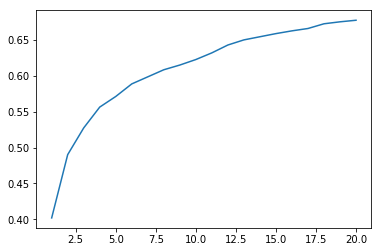

In [13]:
plt.plot(ks, accuracies)

In [29]:
importlib.reload(evaluate)
evaluate.mrr(valid_df['ja'].values,
             tr,
             k=20)

0.5288660969831264